<a href="https://colab.research.google.com/github/ChintPatel/CMPE258-Catchup-Quiz-Multimodal/blob/main/Catchup_Quiz_Multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import random
import os


In [2]:
# Load a few sample images and create dummy captions
IMAGE_COUNT = 6

# Use a few sample images from tf.keras.datasets
(x_train, _), _ = tf.keras.datasets.cifar10.load_data()
sample_images = x_train[:IMAGE_COUNT]

# Generate dummy captions (in real case, you'd load from MS-COCO)
sample_captions = [
    "A dog playing in the park.",
    "A car driving on a street.",
    "Children playing soccer.",
    "A plane flying in the sky.",
    "A person riding a horse.",
    "A ship sailing on the sea."
]


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


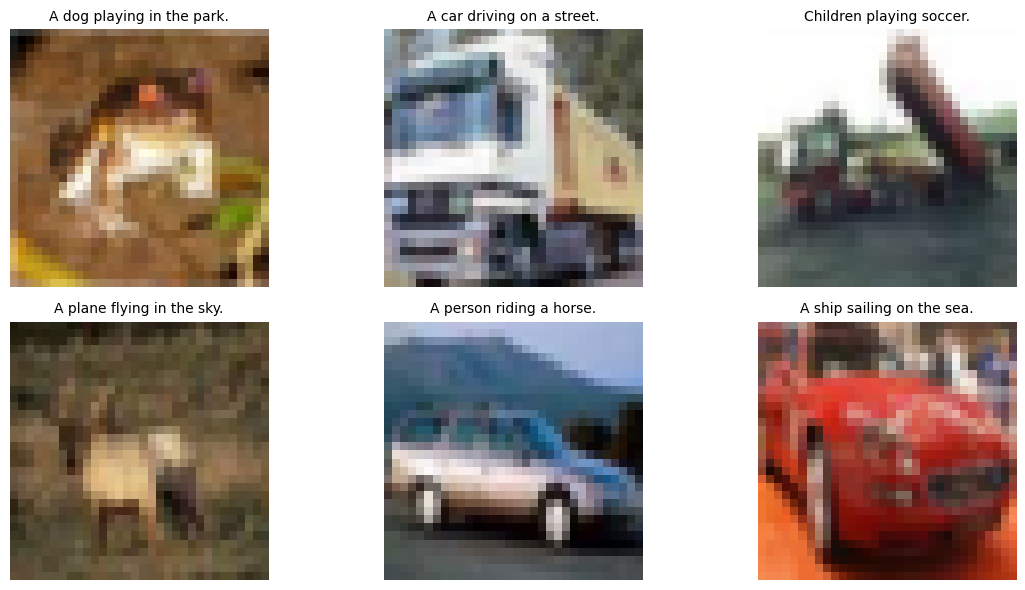

In [3]:
plt.figure(figsize=(12, 6))
for i in range(IMAGE_COUNT):
    plt.subplot(2, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.title(sample_captions[i], fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()


## 🖼️ Image Captioning

In this section, we build a lightweight image captioning system using:
- **MobileNetV2** as a pre-trained CNN to extract visual features
- A simple **GRU decoder** that takes these features and generates captions
This is a simplified version, designed to run quickly on CPU/Colab.


In [4]:
# Load pre-trained MobileNetV2 (no top layer) to extract image features
mobilenet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(mobilenet_url, input_shape=(224, 224, 3))

# Freeze weights to avoid training
feature_extractor.trainable = False


In [5]:
def preprocess_image(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.cast(img, tf.float32) / 255.0
    return img

# Preprocess all sample images
preprocessed_images = tf.stack([preprocess_image(img) for img in sample_images])


In [6]:
image_features = feature_extractor(preprocessed_images)  # Shape: (batch_size, feature_dim)
print("Image feature shape:", image_features.shape)


Image feature shape: (6, 1280)


In [7]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(sample_captions)
caption_seqs = tokenizer.texts_to_sequences(sample_captions)

# Pad all to the same length
caption_padded = tf.keras.preprocessing.sequence.pad_sequences(caption_seqs, padding='post')
vocab_size = len(tokenizer.word_index) + 1

print("Padded captions shape:", caption_padded.shape)
print("Vocab size:", vocab_size)


Padded captions shape: (6, 6)
Vocab size: 23


In [15]:
EMBEDDING_DIM = 128
UNITS = 256
SEQ_LEN = decoder_input.shape[1]  # dynamically grab correct sequence length

# Define the decoder model
image_input = tf.keras.Input(shape=(1280,))  # MobileNetV2 feature dim
caption_input = tf.keras.Input(shape=(SEQ_LEN,))  # tokenized caption input

# Repeat image features to match decoder input length
image_emb = tf.keras.layers.RepeatVector(SEQ_LEN)(image_input)

# Embed the decoder input
caption_emb = tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM)(caption_input)

# Concatenate image + caption embeddings
merged = tf.keras.layers.Concatenate()([image_emb, caption_emb])

# GRU + output
gru_out = tf.keras.layers.GRU(UNITS, return_sequences=True)(merged)
output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(vocab_size, activation='softmax'))(gru_out)

caption_model = tf.keras.Model(inputs=[image_input, caption_input], outputs=output)
caption_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
caption_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1280)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 5, 1280)   │          0 │ input_layer_2[0]… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 5, 128)    │      2,944 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 5, 1408)   │          0 │ repeat_vector_2[… │
│ (Concatenate)       │                   │            │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 5, 256)    │  1,279,488 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 5, 23)     │      5,911 │ gru_1[0][0]       │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,288,343 (4.91 MB)

 Trainable params: 1,288,343 (4.91 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Create shifted output for teacher forcing
decoder_input = caption_padded[:, :-1]
decoder_target = caption_padded[:, 1:]
decoder_target = np.expand_dims(decoder_target, -1)  # Needed for sparse loss


In [16]:
caption_model.fit([image_features, decoder_input], decoder_target, epochs=10)



Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 3.3195
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 2.4077
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 1.8929
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - loss: 1.6719
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - loss: 1.5093
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 1.3676
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 1.2729
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 1.2134
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 1.1586
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.0980


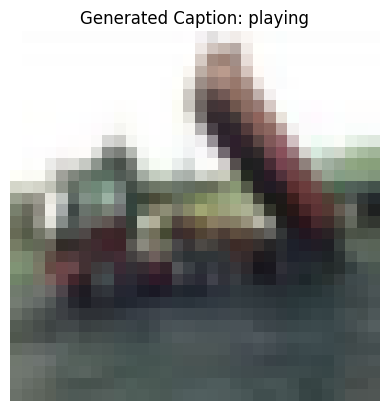

In [18]:
# Simple greedy decoder (just for demo)
index_word = {v: k for k, v in tokenizer.word_index.items()}
index_word[0] = "<PAD>"

def generate_caption(image_feat):
    caption_seq = [tokenizer.word_index['<OOV>']]

    for _ in range(SEQ_LEN):  # generate at most SEQ_LEN words
        # Pad/truncate input to match training time shape
        padded_input = tf.keras.preprocessing.sequence.pad_sequences([caption_seq], maxlen=SEQ_LEN, padding='post')
        pred = caption_model.predict([tf.expand_dims(image_feat, 0), padded_input], verbose=0)
        next_id = tf.argmax(pred[0, len(caption_seq)-1]).numpy()
        if next_id == 0:
            break
        caption_seq.append(next_id)

    return ' '.join([index_word.get(i, '') for i in caption_seq[1:]])


# Test on a sample image
sample_idx = 2
plt.imshow(sample_images[sample_idx])
plt.axis('off')
plt.title("Generated Caption: " + generate_caption(image_features[sample_idx]))
plt.show()


## 🧠 Multimodal Classification

This task combines both **image and text** inputs to classify samples into binary or multiclass categories. We'll:

- Use **MobileNetV2** to extract image features
- Use an **Embedding layer** to represent text inputs
- Combine both modalities using concatenation
- Train a simple **Dense classifier**

The goal is to demonstrate a fast and simple multimodal pipeline using TensorFlow.


In [19]:
# Sample multimodal dataset (images + text + labels)
multi_texts = [
    "A dog in the grass",
    "A car on the road",
    "Boys playing football",
    "Plane flying above clouds",
    "A person rides a horse",
    "Cruise ship on ocean"
]

# Labels (binary: 1=relevant, 0=irrelevant - dummy logic)
multi_labels = [1, 0, 1, 0, 1, 0]

# Use the same sample_images from earlier
multi_images = sample_images


In [20]:
# Tokenize text
text_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<OOV>")
text_tokenizer.fit_on_texts(multi_texts)
text_seqs = text_tokenizer.texts_to_sequences(multi_texts)

# Pad sequences
text_padded = tf.keras.preprocessing.sequence.pad_sequences(text_seqs, padding='post', maxlen=6)

# Vocabulary size
text_vocab_size = len(text_tokenizer.word_index) + 1
print("Text vocab size:", text_vocab_size)


Text vocab size: 23


In [21]:
# Preprocess and extract MobileNetV2 image features
multi_images_pre = tf.stack([preprocess_image(img) for img in multi_images])
multi_img_features = feature_extractor(multi_images_pre)  # Shape: (batch, 1280)


In [22]:
TEXT_SEQ_LEN = text_padded.shape[1]
TEXT_EMB_DIM = 64

# Inputs
img_input = tf.keras.Input(shape=(1280,))
txt_input = tf.keras.Input(shape=(TEXT_SEQ_LEN,))

# Embed text
txt_emb = tf.keras.layers.Embedding(text_vocab_size, TEXT_EMB_DIM)(txt_input)
txt_flat = tf.keras.layers.GlobalAveragePooling1D()(txt_emb)  # (batch, embedding_dim)

# Combine both modalities
combined = tf.keras.layers.Concatenate()([img_input, txt_flat])
dense1 = tf.keras.layers.Dense(64, activation='relu')(combined)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense1)

multi_model = tf.keras.Model(inputs=[img_input, txt_input], outputs=output)
multi_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
multi_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 6, 64)     │      1,472 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 1280)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ embedding_2[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 1344)      │          0 │ input_layer_4[0]… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     86,080 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 87,617 (342.25 KB)

 Trainable params: 87,617 (342.25 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
multi_labels_array = np.array(multi_labels)

multi_model.fit(
    [multi_img_features, text_padded],
    multi_labels_array,
    epochs=20,
    verbose=2
)


Epoch 1/20
1/1 - 1s - 1s/step - accuracy: 0.5000 - loss: 0.7964
Epoch 2/20
1/1 - 0s - 56ms/step - accuracy: 1.0000 - loss: 0.3588
Epoch 3/20
1/1 - 0s - 58ms/step - accuracy: 1.0000 - loss: 0.1624
Epoch 4/20
1/1 - 0s - 57ms/step - accuracy: 1.0000 - loss: 0.0803
Epoch 5/20
1/1 - 0s - 59ms/step - accuracy: 1.0000 - loss: 0.0422
Epoch 6/20
1/1 - 0s - 45ms/step - accuracy: 1.0000 - loss: 0.0238
Epoch 7/20
1/1 - 0s - 60ms/step - accuracy: 1.0000 - loss: 0.0141
Epoch 8/20
1/1 - 0s - 47ms/step - accuracy: 1.0000 - loss: 0.0087
Epoch 9/20
1/1 - 0s - 45ms/step - accuracy: 1.0000 - loss: 0.0057
Epoch 10/20
1/1 - 0s - 45ms/step - accuracy: 1.0000 - loss: 0.0039
Epoch 11/20
1/1 - 0s - 47ms/step - accuracy: 1.0000 - loss: 0.0028
Epoch 12/20
1/1 - 0s - 59ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 13/20
1/1 - 0s - 44ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 14/20
1/1 - 0s - 46ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 15/20
1/1 - 0s - 47ms/step - accuracy: 1.0000 - loss: 9.6803e-04
Ep

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


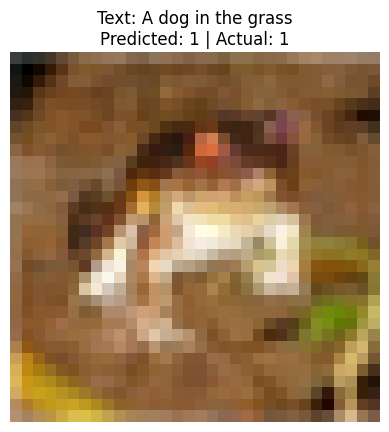

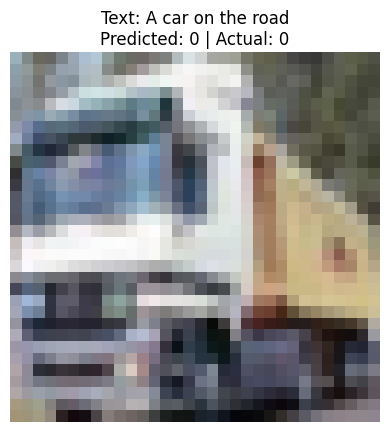

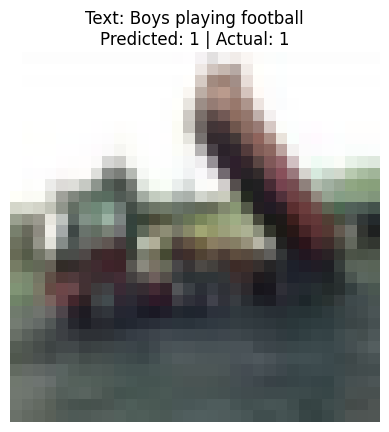

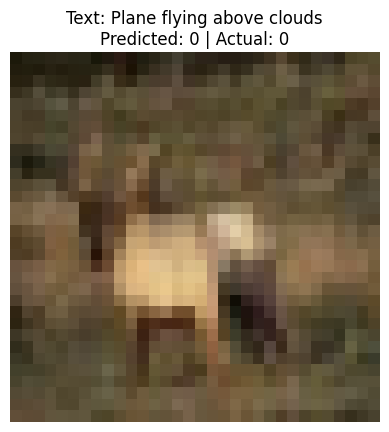

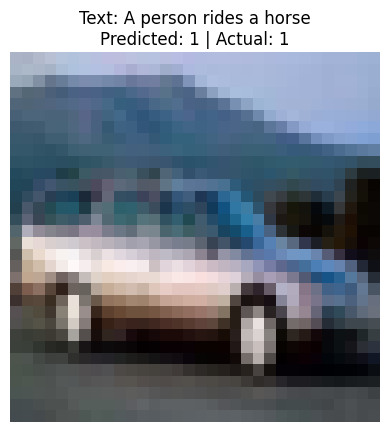

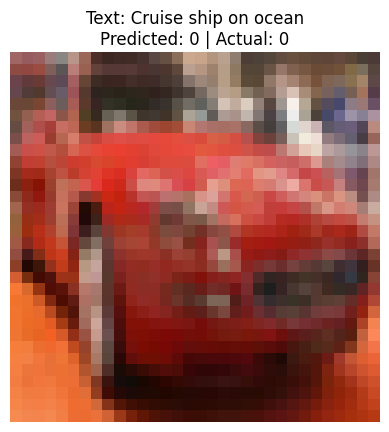

In [24]:
preds = multi_model.predict([multi_img_features, text_padded])
pred_labels = (preds > 0.5).astype(int).flatten()

# Show predictions
for i in range(len(multi_images)):
    plt.imshow(multi_images[i])
    plt.axis('off')
    plt.title(f"Text: {multi_texts[i]}\nPredicted: {pred_labels[i]} | Actual: {multi_labels[i]}")
    plt.show()


## 🔍 Multimodal Retrieval

In this section, we implement a basic **multimodal retrieval** system that matches images with text queries.
The idea is to embed both **images** and **text descriptions** into a shared feature space and then compute **cosine similarity**.

We use:
- MobileNetV2 for image embeddings
- Global average-pooled text embeddings for queries


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

🔹 Query: "A dog playing in the park."
📸 Top Retrieved Image:


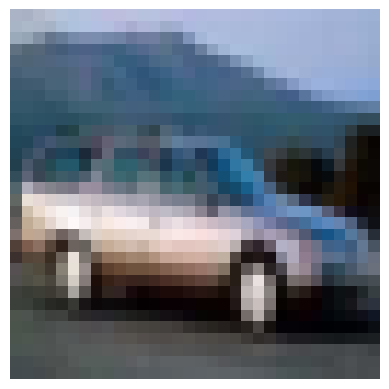


🔹 Query: "A car driving on a street."
📸 Top Retrieved Image:


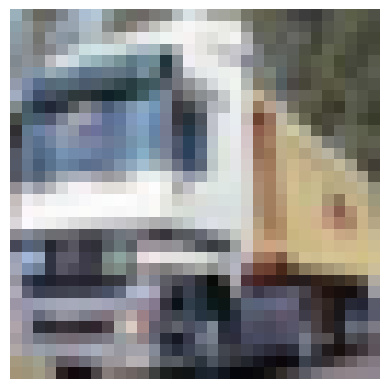


🔹 Query: "Children playing soccer."
📸 Top Retrieved Image:


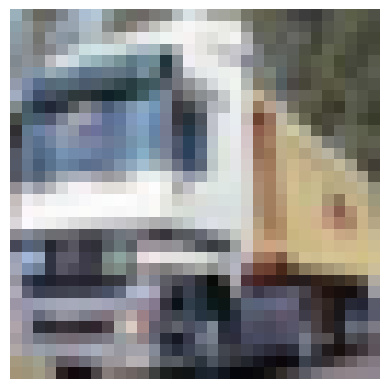


🔹 Query: "A plane flying in the sky."
📸 Top Retrieved Image:


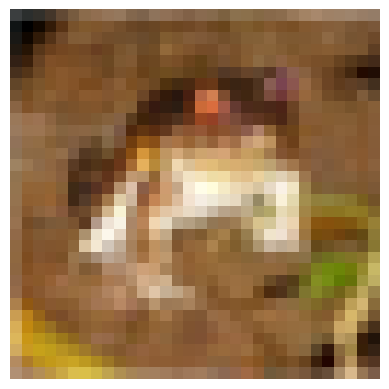


🔹 Query: "A person riding a horse."
📸 Top Retrieved Image:


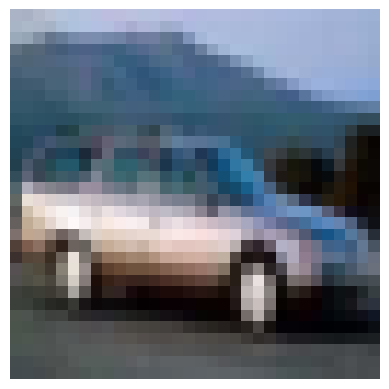


🔹 Query: "A ship sailing on the sea."
📸 Top Retrieved Image:


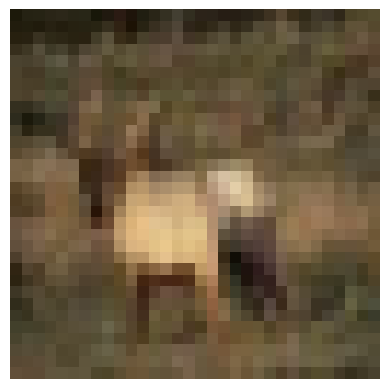

In [26]:
import tensorflow.keras.backend as K
from sklearn.metrics.pairwise import cosine_similarity

# Reuse previously preprocessed images
retrieval_images = sample_images
retrieval_texts = sample_captions  # same descriptions from Part 1

# Extract image embeddings again (already done earlier, but repeat here for clarity)
retrieval_preprocessed = tf.stack([preprocess_image(img) for img in retrieval_images])
img_embeddings = feature_extractor(retrieval_preprocessed).numpy()

# Tokenize text and embed
retrieval_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<OOV>")
retrieval_tokenizer.fit_on_texts(retrieval_texts)
text_seq = retrieval_tokenizer.texts_to_sequences(retrieval_texts)
text_pad = tf.keras.preprocessing.sequence.pad_sequences(text_seq, padding='post', maxlen=6)

# Simple embedding model for text
VOCAB_SIZE = len(retrieval_tokenizer.word_index) + 1
EMB_DIM = 64

text_input = tf.keras.Input(shape=(text_pad.shape[1],))
text_emb = tf.keras.layers.Embedding(VOCAB_SIZE, EMB_DIM)(text_input)
text_vec = tf.keras.layers.GlobalAveragePooling1D()(text_emb)
text_model = tf.keras.Model(inputs=text_input, outputs=text_vec)

# Generate text embeddings
text_embeddings = text_model.predict(text_pad)

# Project both into a shared space (e.g., 256D)
PROJ_DIM = 256

# Dense layers to match embedding dimensions
img_proj_layer = tf.keras.layers.Dense(PROJ_DIM)
txt_proj_layer = tf.keras.layers.Dense(PROJ_DIM)

img_proj = img_proj_layer(img_embeddings)
text_proj = txt_proj_layer(text_embeddings)

# Normalize for cosine similarity
img_norm = img_proj / np.linalg.norm(img_proj, axis=1, keepdims=True)
text_norm = text_proj / np.linalg.norm(text_proj, axis=1, keepdims=True)


# Compute cosine similarity matrix (text queries x images)
similarity_matrix = cosine_similarity(text_norm, img_norm)

# Show top retrieval result for each text
for i in range(len(retrieval_texts)):
    best_match = np.argmax(similarity_matrix[i])
    print(f"\n🔹 Query: \"{retrieval_texts[i]}\"")
    print(f"📸 Top Retrieved Image:")
    plt.imshow(retrieval_images[best_match])
    plt.axis('off')
    plt.show()


## ✅ Conclusion

In this notebook, we demonstrated three practical use cases of lightweight **multimodal deep learning** using TensorFlow:

1. **Image Captioning** — Generated text captions from image features using MobileNetV2 + GRU.
2. **Multimodal Classification** — Combined image and text features to classify inputs into binary categories.
3. **Multimodal Retrieval** — Matched image-text pairs based on cosine similarity in a shared embedding space.

These examples use fast, low-resource models and are ideal for academic demos, project prototypes, or quick experiments on Colab. They show how vision and language models can be integrated in meaningful ways, even with minimal data and compute.

---
